In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


### Ładowanie danych

In [35]:
def load_and_preprocess(file_path):
    data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').drop_duplicates('timestamp')
    return data

##### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def isolation_forest_IQR_window(data, column='energy_consumption', window_size=24):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]]).flatten()

    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    outlier_mask = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
    contamination = max(0.001, min(0.5, np.sum(outlier_mask) / len(values)))

    sequences = create_sequences(values, window_size)
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(sequences)

    preds = model.predict(sequences)  # -1 dla anomalii, 1 dla normalnych
    binary_preds = (preds == -1).astype(int)

    # Głosowanie przez nakładające się okna
    anomaly_scores = np.zeros(len(values))
    counts = np.zeros(len(values))

    for i in range(len(binary_preds)):
        if binary_preds[i] == 1:
            anomaly_scores[i:i+window_size] += 1
        counts[i:i+window_size] += 1

    avg_scores = np.divide(anomaly_scores, counts, out=np.zeros_like(anomaly_scores), where=counts != 0)
    final_labels = (avg_scores > 0.5).astype(int)

    data['isolation_forest'] = final_labels
    return data

def isolation_forest_95(data, column='energy_consumption', contamination_quantile=0.95):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Train initial model to get scores
    model = IsolationForest(contamination='auto')
    model.fit(values)
    scores = model.decision_function(values)  # The lower, the more abnormal

    # Estimate contamination based on quantile of scores
    threshold = np.quantile(scores, 1 - contamination_quantile)
    predicted = (scores < threshold).astype(int)

    data['isolation_forest'] = predicted
    return data

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def isolation_forest_IQR(data, column='energy_consumption', contamination=0.05):
    data = data.copy()
    
    # Check if column exists
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    # Scale the specified column
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    
    # Train Isolation Forest model
    model = IsolationForest(
        contamination="auto",
        n_estimators=500,
    )
    

    scores = model.fit_predict(values)
    decision_scores = model.decision_function(values)

    q1 = np.percentile(decision_scores, 25)
    q3 = np.percentile(decision_scores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr

    threshold = np.quantile(decision_scores, 0.01) 
    data['isolation_forest'] = decision_scores < threshold
    
    return data


##### LSTM Autoencoder

In [192]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def lstm_autoencoder(data, column='energy_consumption', window_size=24, iqr_multiplier=1.5, epochs=50, batch_size=32):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    if len(values) < window_size + 1:
        raise ValueError(f"Not enough data points ({len(values)}) for window size {window_size}")
    X = create_sequences(values, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    def build_model(hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            input_shape=(window_size, 1),
            return_sequences=False))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(RepeatVector(window_size))
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=True))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(TimeDistributed(Dense(1)))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
            loss='mse',
            metrics=['mae'])
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning',
        project_name='energy_forecast'
    )

    tuner.search(X, X, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]

    best_model.fit(X, X, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    pred = best_model.predict(X)
    mae = np.mean(np.abs(pred - X), axis=(1, 2))

    q1 = np.percentile(mae, 25)
    q3 = np.percentile(mae, 75)
    iqr = q3 - q1
    
    ub = q3 + iqr_multiplier * iqr
    lb = q1 - iqr_multiplier * iqr

    anomalies = np.zeros(len(data))
    anomaly_scores = np.zeros(len(data))
    window_counts = np.zeros(len(data))

    for i in range(len(mae)):
        if mae[i] > ub or mae[i] < lb:
            anomaly_scores[i:i + window_size] += 1
        window_counts[i:i + window_size] += 1

    anomaly_scores = np.where(window_counts > 0, anomaly_scores / window_counts, 0)
    anomalies[anomaly_scores > 0.5] = 1

    data['lstm_autoencoder'] = anomalies
    return data


##### IQR

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def dynamic_iqr(timeseries, w=None, k=1.5):

    timeseries = pd.Series(timeseries).dropna().reset_index(drop=True)
    anomalies = np.zeros(len(timeseries), dtype=bool)

    if w is None or w >= len(timeseries):
        Q1 = timeseries.quantile(0.25)
        Q3 = timeseries.quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - k * IQR
        ub = Q3 + k * IQR
        anomalies = (timeseries < lb) | (timeseries > ub)
    else:
        for i in range(len(timeseries)):
            start = max(0, i - w // 2)
            end = min(len(timeseries), i + w // 2)
            window = timeseries[start:end]
            Q1 = window.quantile(0.25)
            Q3 = window.quantile(0.75)
            IQR = Q3 - Q1
            lb = Q1 - k * IQR
            if timeseries[i] < lb:
                anomalies[i] = True

    return timeseries, anomalies


##### RUN

In [39]:

dataW = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstmW = dataW
IF_resultsW = isolation_forest_IQR_window(data=dataW)
LSTM_resultsW = lstm_autoencoder(data_lstmW, window_size=24)
timeseriesW, IQR_resultsW = dynamic_iqr(dataW['energy_consumption'], w=24, k=1.5)

data2W = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2W = data2W
IF_results2W = isolation_forest_IQR_window(data=data2W)
LSTM_results2W = lstm_autoencoder(data_lstm2W, window_size=24)
timeseries2W, IQR_results2W = dynamic_iqr(data2W['energy_consumption'], w=24, k=1.5)


data3W = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3W = data3W
IF_results3W = isolation_forest_IQR_window(data=data3W)
LSTM_results3W = lstm_autoencoder(data_lstm3W, window_size=24)
timeseries3W, IQR_results3W = dynamic_iqr(data3W['energy_consumption'], w=24, k=1.5)


Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 2.9153e-04 - mae: 0.0115 - val_loss: 5.1744e-04 - val_mae: 0.0085
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.5812e-04 - mae: 0.0076 - val_loss: 5.0771e-04 - val_mae: 0.0084
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.4335e-04 - mae: 0.0071 - val_loss: 4.8808e-04 - val_mae: 0.0084
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 1.3834e-04 - mae: 0.0068 - val_loss: 4.9230e-04 - val_mae: 0.0085
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.3343e-04 - mae: 0.0067 - val_loss: 5.1686e-04 - val_mae: 0.0085
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 1.6193e-04 - mae: 0.0068 - val_loss: 4.8566e-04 - val_mae: 0.0084
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.3510e-04 - mae: 0.0065 - val_loss: 4.9349e-04 - val_mae: 0.0092
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.2484e-04 - mae: 0.0064 - val_loss: 4.6908e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 8.5090e-05 - mae: 0.0049 - val_loss: 4.3980e-04 - val_mae: 0.0049
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 8.4880e-05 - mae: 0.0041 - val_loss: 4.4807e-04 - val_mae: 0.0050
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.4338e-05 - mae: 0.0039 - val_loss: 4.6283e-04 - val_mae: 0.0050
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 5.9018e-05 - mae: 0.0037 - val_loss: 4.7000e-04 - val_mae: 0.0050
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 8.3059e-05 - mae: 0.0038 - val_loss: 4.7580e-04 - val_mae: 0.0051
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.7859e-05 - mae: 0.0037 - val_loss: 4.8128e-04 - val_mae: 0.0051
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.8633e-05 - mae: 0.0036 - val_loss: 4.9489e-04 - val_mae: 0.0049
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.8191e-05 - mae: 0.0035 - val_loss: 5.0165e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 2.1401e-04 - mae: 0.0079 - val_loss: 9.8235e-06 - val_mae: 0.0025
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.0117e-04 - mae: 0.0034 - val_loss: 2.8913e-06 - val_mae: 0.0013
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 1.0913e-04 - mae: 0.0029 - val_loss: 3.0209e-06 - val_mae: 0.0013
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.0238e-04 - mae: 0.0025 - val_loss: 4.9953e-06 - val_mae: 0.0015
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.8513e-05 - mae: 0.0022 - val_loss: 2.3636e-06 - val_mae: 0.0011
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 8.2179e-05 - mae: 0.0021 - val_loss: 3.9788e-06 - val_mae: 0.0015
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 9.1291e-05 - mae: 0.0022 - val_loss: 3.2534e-06 - val_mae: 0.0013
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.5083e-05 - mae: 0.0020 - val_loss: 9.4979e-06 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

In [91]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

Epoch 1/50


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

NameError: name 'data' is not defined

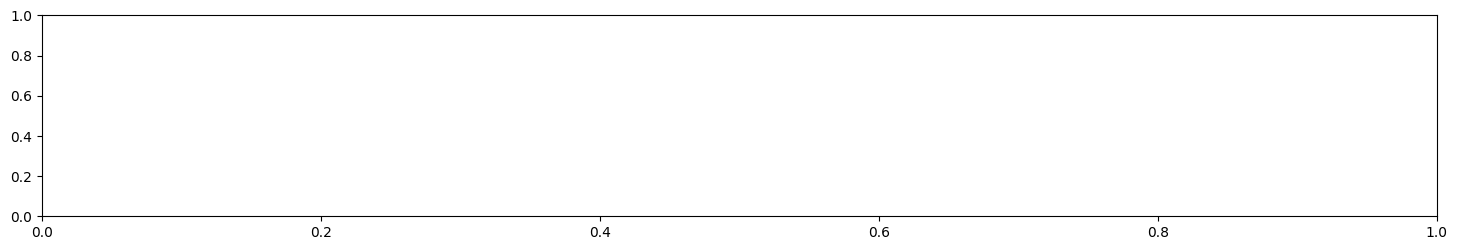

In [13]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data[-8760:]['timestamp'], data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries[IQR_results].index, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data[-8760:]['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

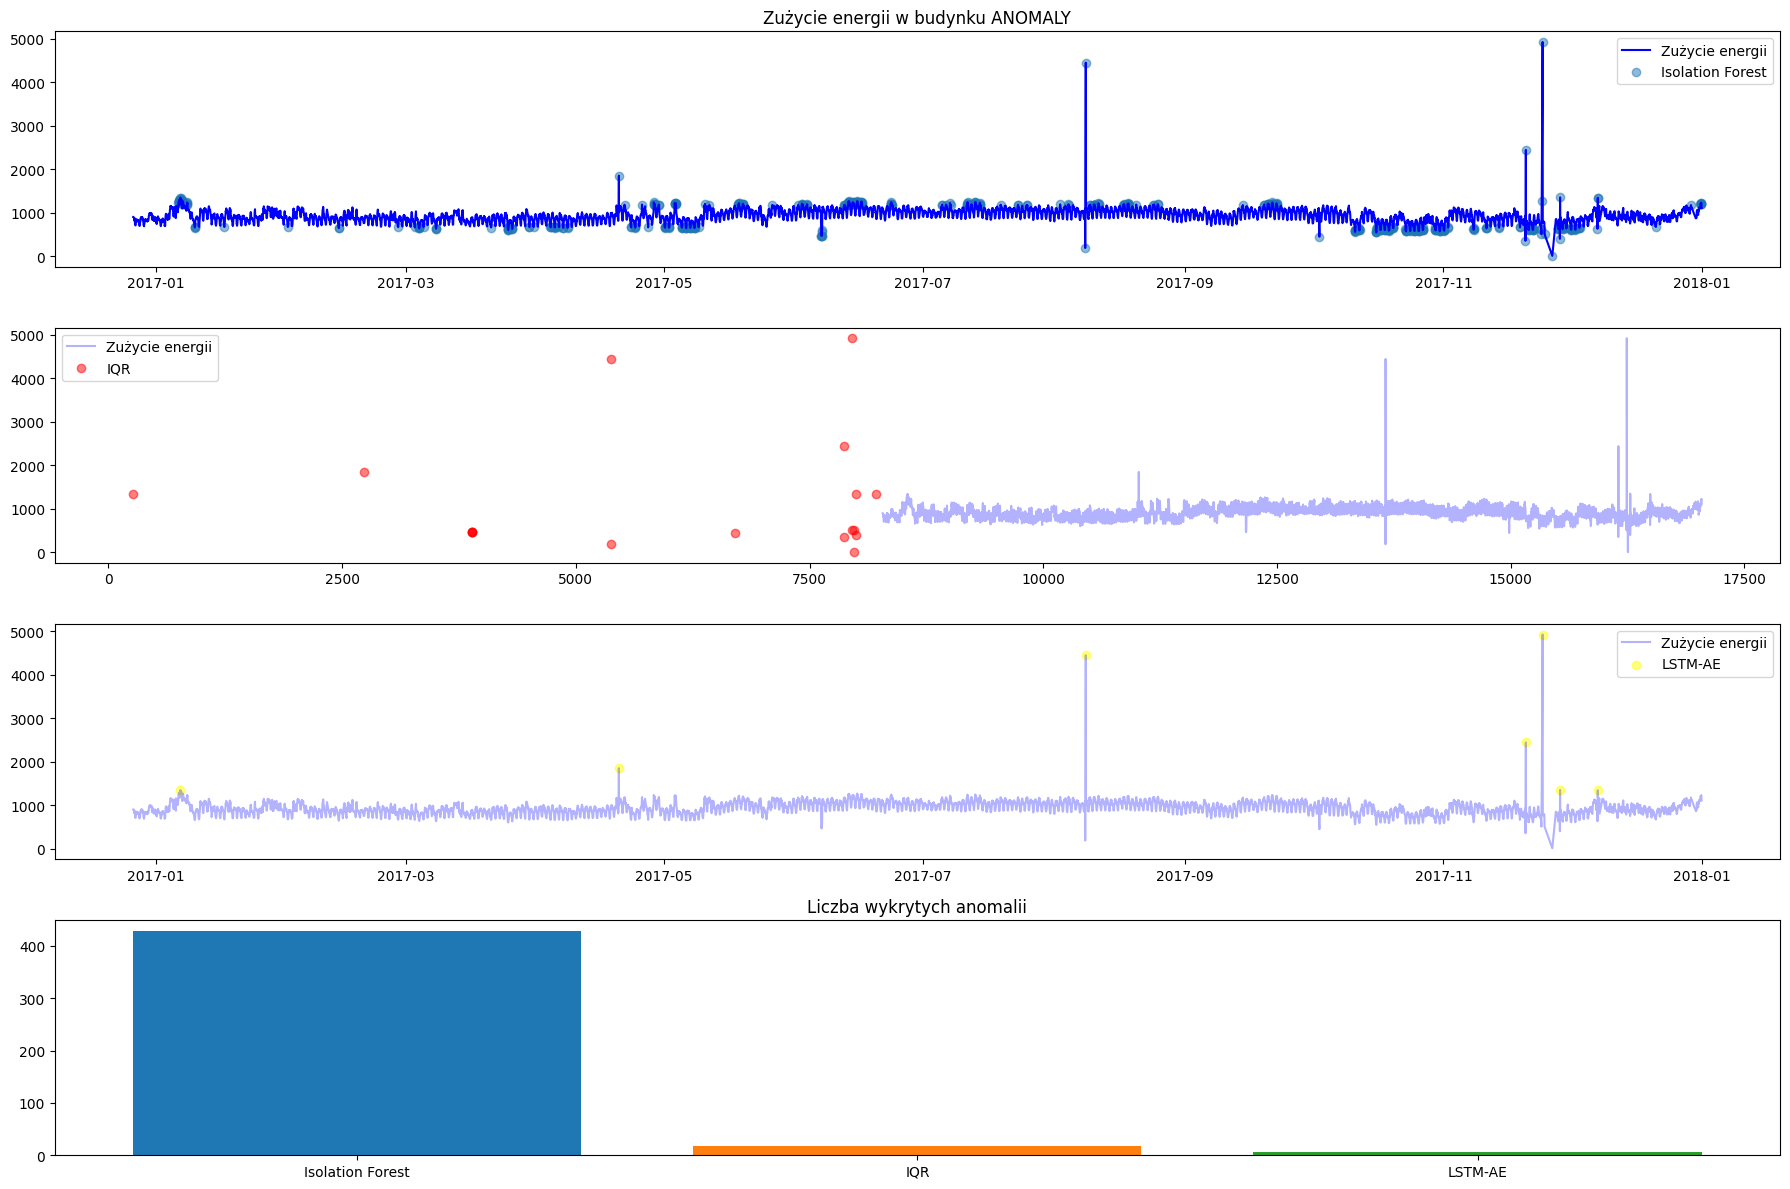

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

In [ ]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========


NameError: name 'timeseries' is not defined

--- ANOMALY 1

Liczba anomalii wykrytych przez IQR: 24/39\
Liczba anomalii wykrytych przez IQR spoza zakresu: 9\
Liczba anomalii wykrytych przez IF: 39/39\
Liczba anomalii wykrytych przez IF spoza zakresu: 131\
Liczba anomalii wykrytych przez LSTM-AE: 36/39\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 439

--- ANOMALY 2

Liczba anomalii wykrytych przez IQR: 20/51\
Liczba anomalii wykrytych przez IQR spoza zakresu: 0\
Liczba anomalii wykrytych przez IF: 51/51\
Liczba anomalii wykrytych przez IF spoza zakresu: 70\
Liczba anomalii wykrytych przez LSTM-AE: 49/51\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 579

--- ANOMALY 3

Liczba anomalii wykrytych przez IQR: 38/62\
Liczba anomalii wykrytych przez IQR spoza zakresu: 8\
Liczba anomalii wykrytych przez IF: 62/62\
Liczba anomalii wykrytych przez IF spoza zakresu: 54\
Liczba anomalii wykrytych przez LSTM-AE: 49/62\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 796

### Wyniki dla ostatniego roku
=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 39/39
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 39/39
Liczba anomalii wykrytych przez IF spoza zakresu: 799
Liczba anomalii wykrytych przez LSTM-AE: 4/39
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 3
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/51
Liczba anomalii wykrytych przez IQR spoza zakresu: 17
Liczba anomalii wykrytych przez IF: 51/51
Liczba anomalii wykrytych przez IF spoza zakresu: 552
Liczba anomalii wykrytych przez LSTM-AE: 24/51
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 7
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 330
Liczba anomalii wykrytych przez LSTM-AE: 29/62
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 88




In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

data = [
    ("IQR", "I", 34, 5, 132, 16871),
    ("IQR", "II", 30, 21, 10, 11999),
    ("IQR", "III", 50, 12, 40, 7721),
    ("IF z percentylem 0.95", "I", 39, 0, 802, 16201),
    ("IF z percentylem 0.95", "II", 51, 0, 549, 11460),
    ("IF z percentylem 0.95", "III", 62, 0, 330, 7431),

    ("IF z IQR", "I", 38, 1, 3, 12018),
    ("IF z IQR", "II", 44, 7, 17, 11992),
    ("IF z IQR", "III", 62, 0, 85, 7676),
    
    ("LSTM-AE", "I", 38, 1, 761, 16242),
    ("LSTM-AE", "II", 50, 1, 819, 11190),
    ("LSTM-AE", "III", 49, 13, 769, 6992),
]

df = pd.DataFrame(data, columns=["Model", "Budynek", "TP", "FN", "FP", "TN"])

df["Precision"] = df["TP"] / (df["TP"] + df["FP"])
df["Recall"] = df["TP"] / (df["TP"] + df["FN"])
df["F1-score"] = 2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])
df["Accuracy"] = (df["TP"] + df["TN"]) / (df["TP"] + df["TN"] + df["FP"] + df["FN"])

df_metrics_1 = df[["Model", "Budynek", "Precision", "Recall", "F1-score", "Accuracy"]].round(4)
df_metrics_1

,Model,Budynek,Precision,Recall,F1-score,Accuracy
0,IQR,I,0.2048,0.8718,0.3317,0.9920
1,IQR,II,0.7500,0.5882,0.6593,0.9974
2,IQR,III,0.5556,0.8065,0.6579,0.9934
3,IF z percentylem 0.95,I,0.0464,1.0000,0.0886,0.9529
4,IF z percentylem 0.95,II,0.0850,1.0000,0.1567,0.9545
5,IF z percentylem 0.95,III,0.1582,1.0000,0.2731,0.9578
6,IF z IQR,I,0.9268,0.9744,0.9500,0.9997
7,IF z IQR,II,0.7213,0.8627,0.7857,0.9980
8,IF z IQR,III,0.4218,1.0000,0.5933,0.9891
9,LSTM-AE,I,0.0476,0.9744,0.0907,0.9553


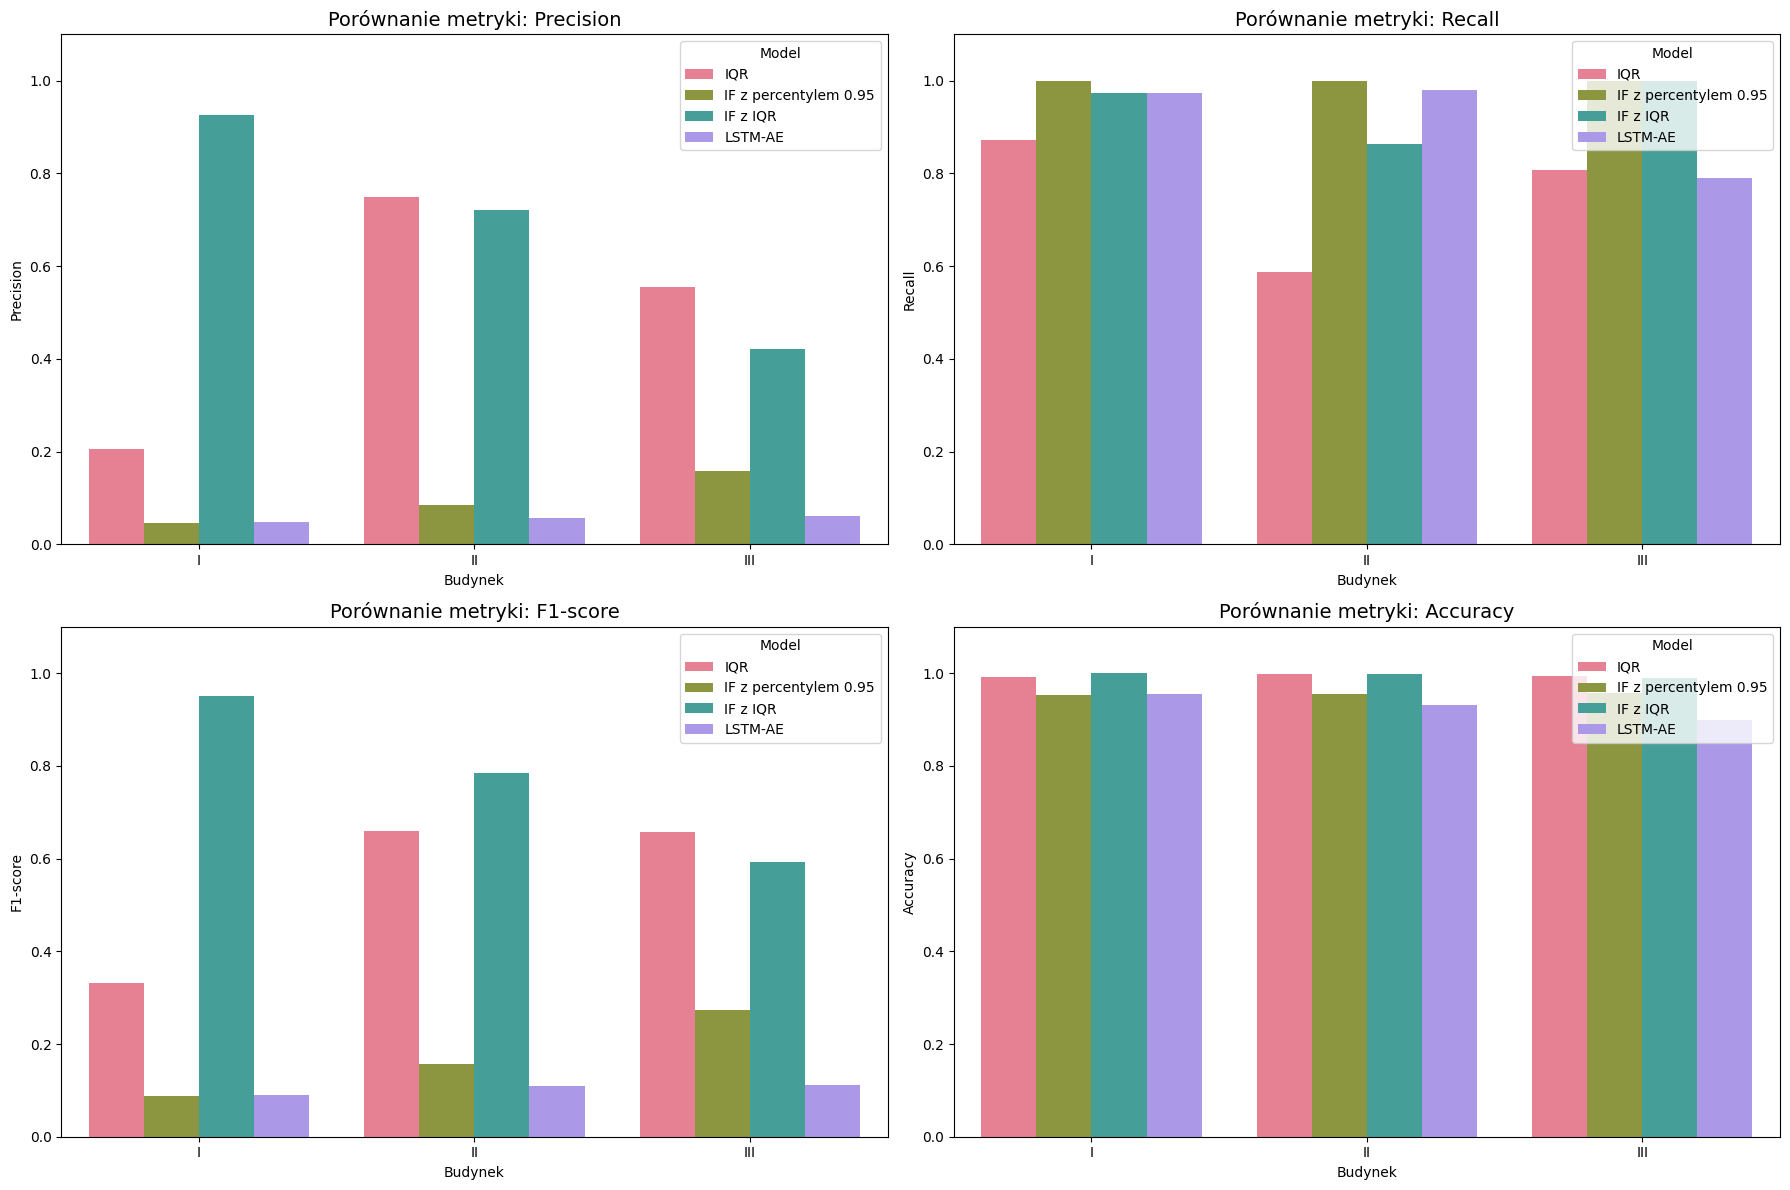

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.DataFrame(df_metrics_1, columns=['Model', 'Budynek', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
df1['Tabela'] = 'Tabela 1'

metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
unique_models = df1['Model'].unique()
palette = sns.color_palette("husl", len(unique_models))
model_colors = dict(zip(unique_models, palette))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    df_sorted = df1.copy()
    df_sorted['sort_key'] = df_sorted.groupby('Budynek')[metric].rank(ascending=False, method='first')
    df_sorted = df_sorted.sort_values(by=['Budynek', 'sort_key'])
    df_sorted.reset_index(drop=True, inplace=True)
    
    sns.barplot(
        data=df_sorted,
        x='Budynek',
        y=metric,
        hue='Model',
        ax=ax,
        errorbar=None,
        dodge=True,
        palette=model_colors,
        hue_order=unique_models
    )
    
    ax.set_title(f'Porównanie metryki: {metric}', fontsize=14)
    ax.set_ylabel(metric)
    ax.set_xlabel('Budynek')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Model')

plt.tight_layout()
plt.show()

### Z oknami, ROK

In [41]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseriesW[IQR_resultsW].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseriesW[IQR_resultsW].index)) - c}")

c = 0

for i in list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2W[IQR_results2W].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2W[IQR_results2W].index)) - c}")

c = 0

for i in list(IF_results2W[IF_results2W['isolation_forest'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2W[IF_results2W['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3W[IQR_results3W].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3W[IQR_results3W].index)) - c}")

c = 0

for i in list(IF_results3W[IF_results3W['isolation_forest'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3W[IF_results3W['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 0/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 81
Liczba anomalii wykrytych przez IF: 0/16
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM-AE: 15/16
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 592
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 0/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 34
Liczba anomalii wykrytych przez IF: 7/47
Liczba anomalii wykrytych przez IF spoza zakresu: 28
Liczba anomalii wykrytych przez LSTM-AE: 45/47
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 388
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 50/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 40
Liczba anomalii wykrytych przez IF: 2/62
Liczba anomalii wykrytych przez IF spoza zakresu: 136
Liczba anomalii wykrytych przez LSTM-AE: 55/62
Liczba anomalii wykrytych przez LSTM-AE spoza 

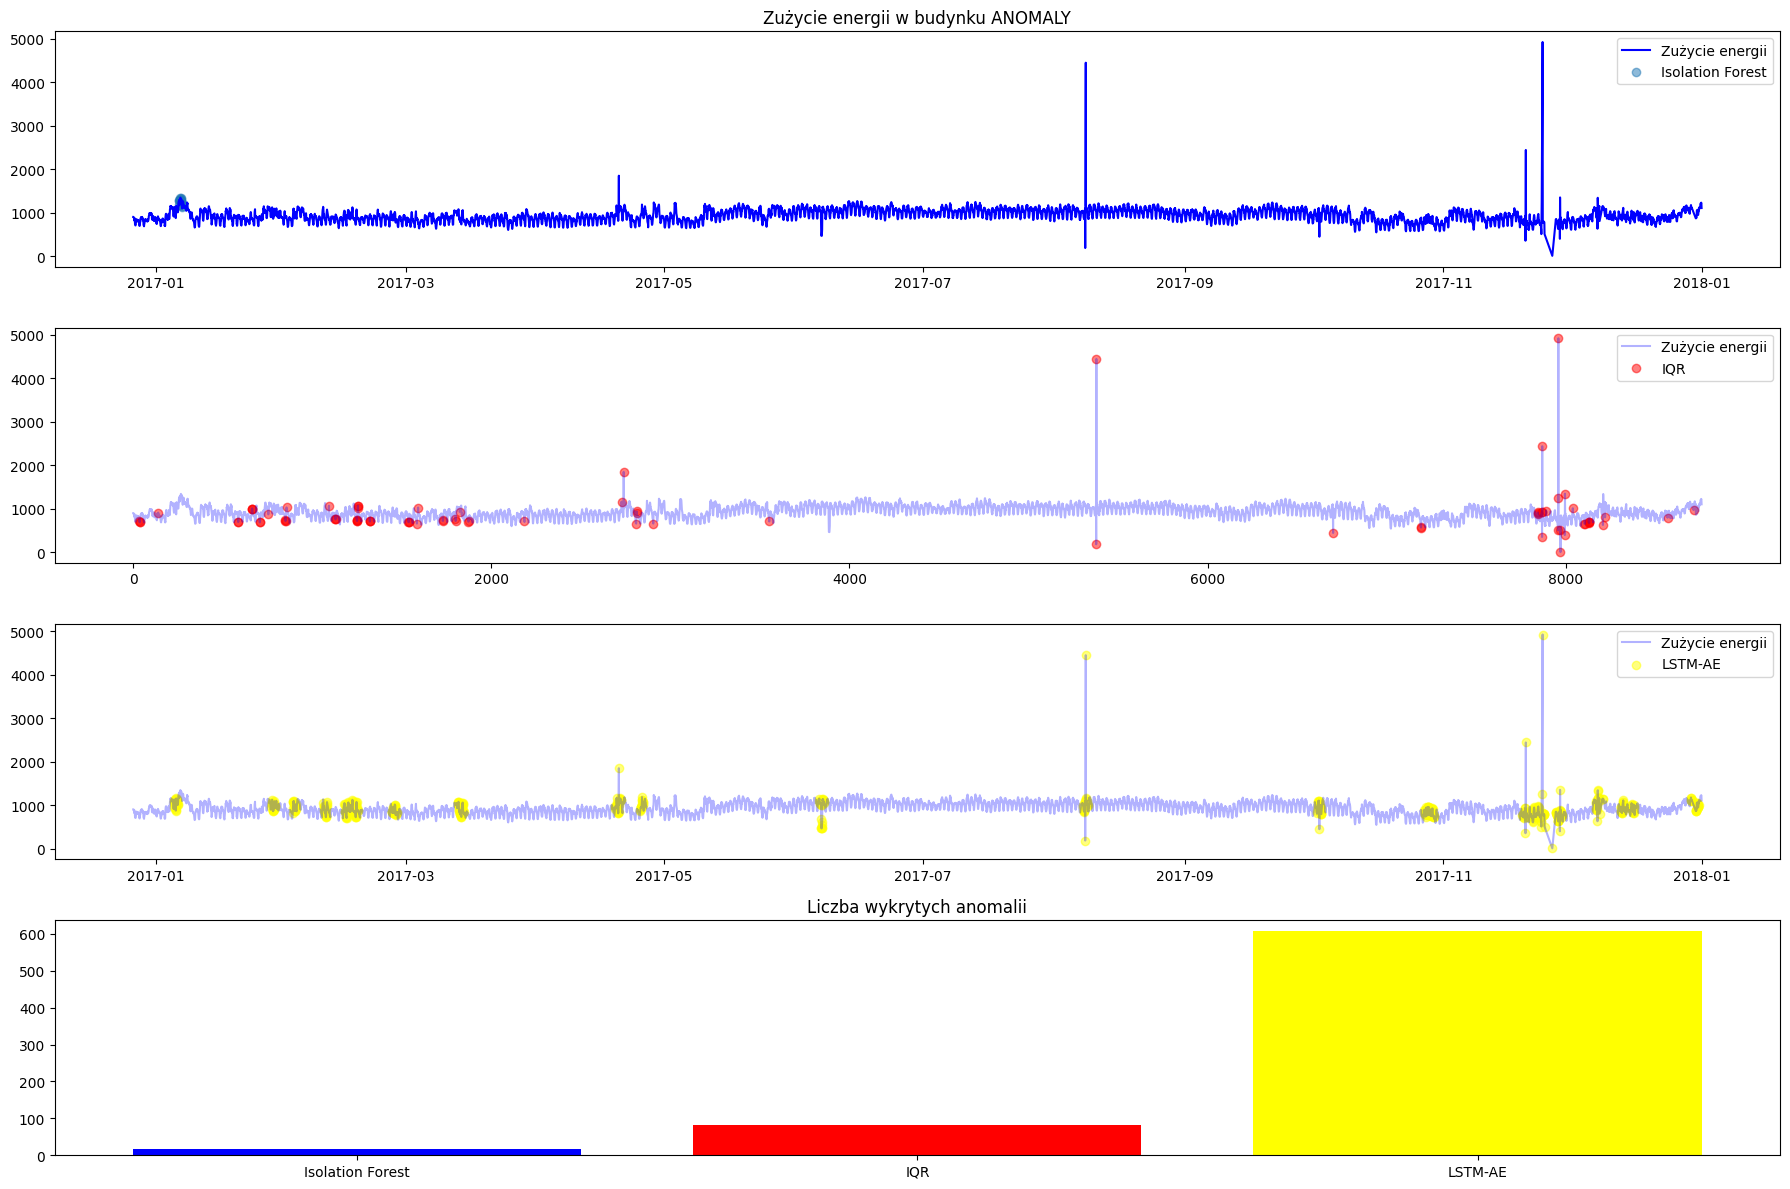

In [43]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IFW = IF_resultsW[IF_resultsW['isolation_forest'] == 1].count()
counts_IQRW = timeseriesW[IQR_resultsW].count()
counts_LSTMW = LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IFW,color='blue')
plt.bar('IQR', counts_IQRW, color='red')
plt.bar('LSTM-AE', counts_LSTMW, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

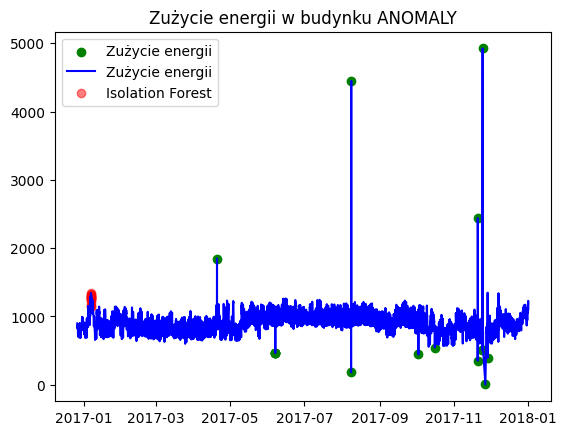

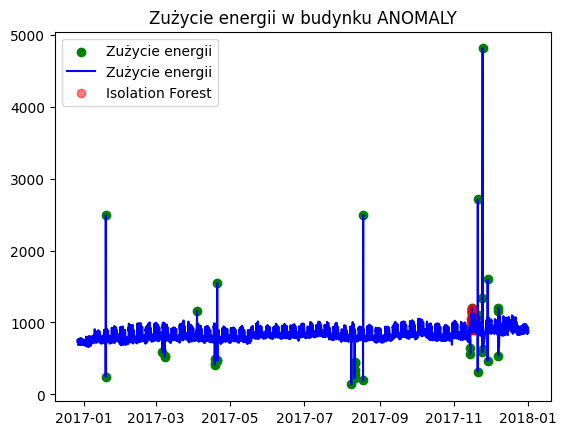

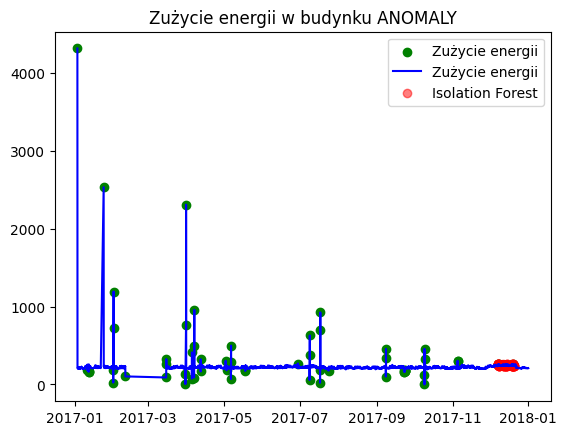

In [56]:
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2W['timestamp'][IF_results2W['isolation_forest'] == 1], IF_results2W['energy_consumption'][IF_results2W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3W['timestamp'][IF_results3W['isolation_forest'] == 1], IF_results3W['energy_consumption'][IF_results3W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


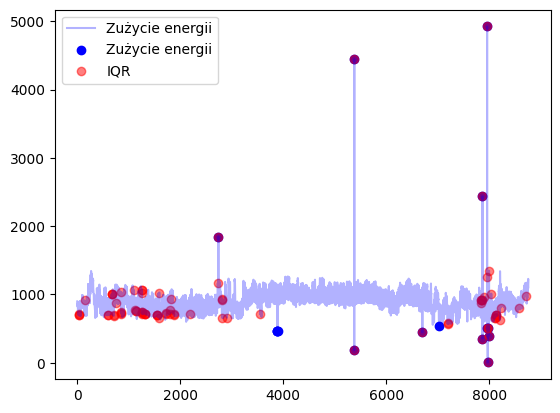

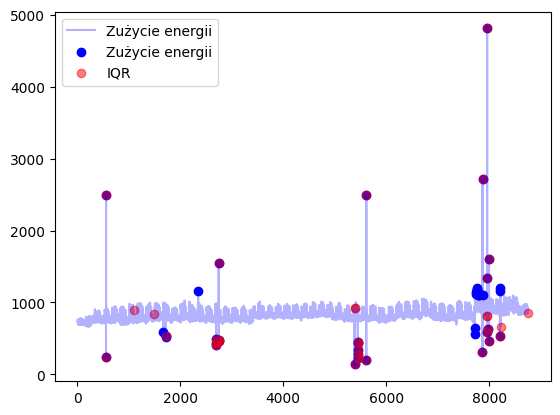

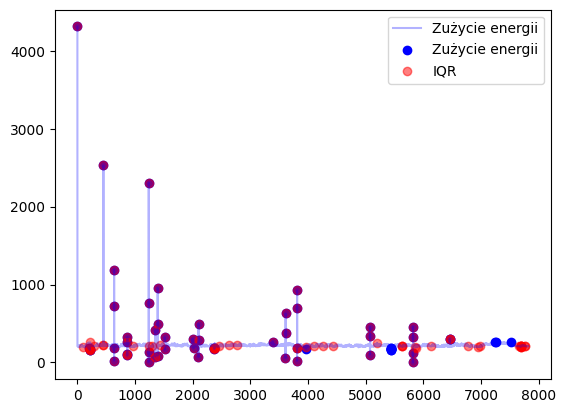

In [90]:
temp = dataW.reset_index().drop(columns=['index'])
temp2 = data2W.reset_index().drop(columns=['index'])
temp3 = data3W.reset_index().drop(columns=['index'])

plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp[temp['anomaly'] == True].index, temp[temp['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2[temp2['anomaly'] == True].index, temp2[temp2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2W[IQR_results2W].index, timeseries2W[IQR_results2W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3[temp3['anomaly'] == True].index, temp3[temp3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3W[IQR_results3W].index, timeseries3W[IQR_results3W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



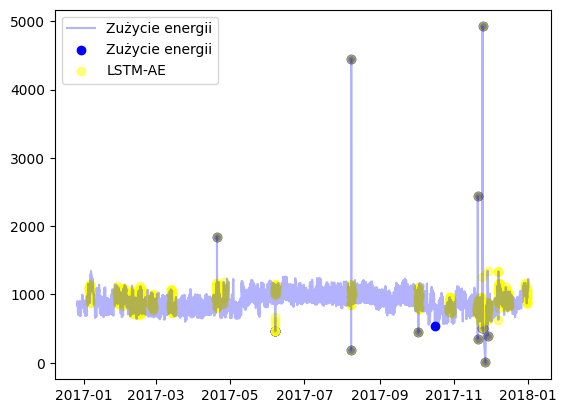

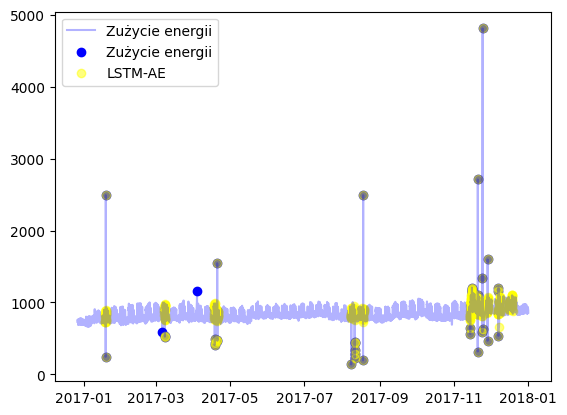

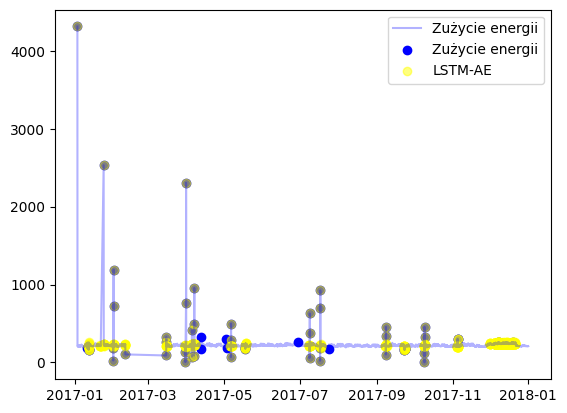

In [65]:

plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results2W['timestamp'][LSTM_results2W['lstm_autoencoder'] == 1], LSTM_results2W['energy_consumption'][LSTM_results2W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results3W['timestamp'][LSTM_results3W['lstm_autoencoder'] == 1], LSTM_results3W['energy_consumption'][LSTM_results3W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

### Bez okien, ROK

In [103]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
# LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

In [104]:
data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
#LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
#LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

In [105]:
tempN = data.reset_index().drop(columns=['index'])
temp2N = data2.reset_index().drop(columns=['index'])
temp3N = data3.reset_index().drop(columns=['index'])

print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(tempN[tempN['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
#     if i in list(data[data['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(temp2N[temp2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
#     if i in list(data2[data2['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(temp3N[temp3N['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


# for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
#     if i in list(data3[data3['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 15/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 16/16
Liczba anomalii wykrytych przez IF spoza zakresu: 403
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 7
Liczba anomalii wykrytych przez IF: 47/47
Liczba anomalii wykrytych przez IF spoza zakresu: 389
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 329


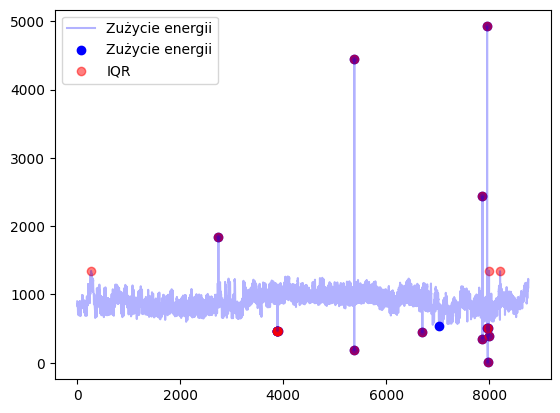

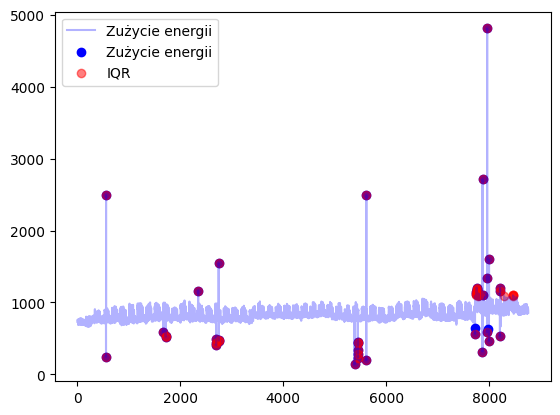

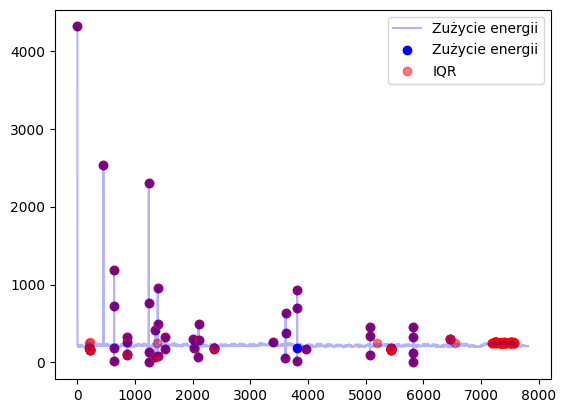

In [106]:
plt.plot(timeseries, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(tempN[tempN['anomaly'] == True].index, tempN[tempN['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_results].index, timeseriesW[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2N[temp2N['anomaly'] == True].index, temp2N[temp2N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2[IQR_results2].index, timeseries2[IQR_results2], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3N[temp3N['anomaly'] == True].index, temp3N[temp3N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3[IQR_results3].index, timeseries3[IQR_results3], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



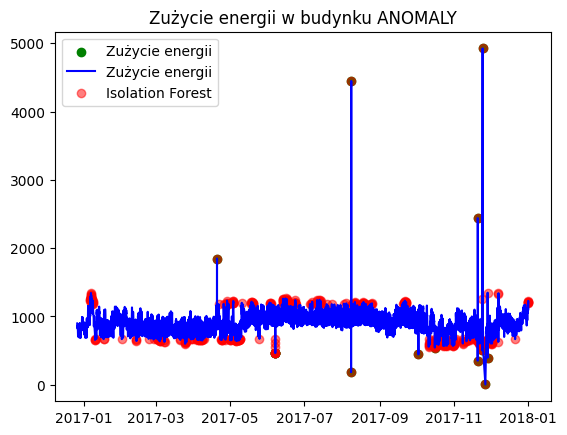

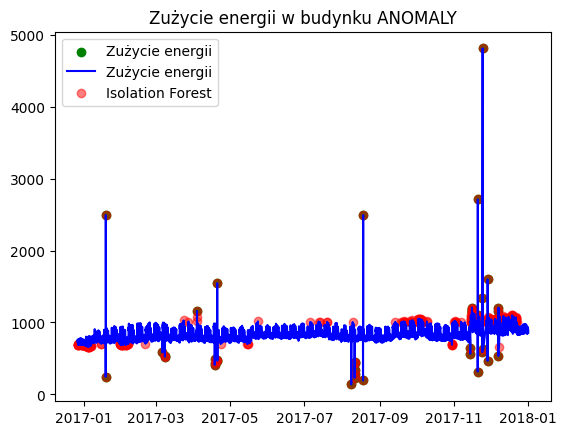

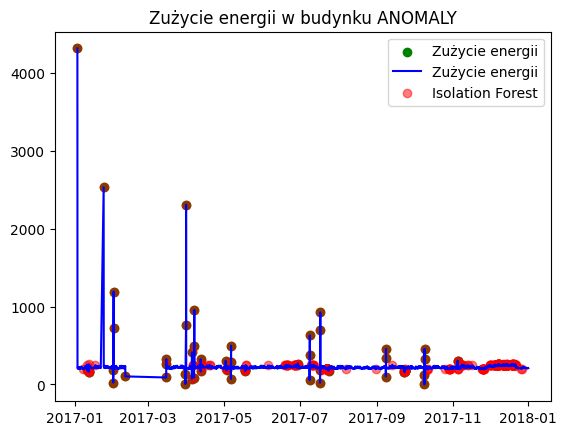

In [107]:
plt.scatter(data[data['anomaly'] == True]['timestamp'], data[data['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2[data2['anomaly'] == True]['timestamp'], data2[data2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2['timestamp'], data2['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2['timestamp'][IF_results2['isolation_forest'] == 1], IF_results2['energy_consumption'][IF_results2['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3[data3['anomaly'] == True]['timestamp'], data3[data3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3['timestamp'], data3['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3['timestamp'][IF_results3['isolation_forest'] == 1], IF_results3['energy_consumption'][IF_results3['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


### WYBÓR MODELI

In [232]:
d = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
d_lstm = d
# resIF = isolation_forest_IQR(data=d)
# resLSTM = lstm_autoencoder(d_lstm, window_size=24, iqr_multiplier=4.5)
t, resIQR = dynamic_iqr(d['energy_consumption'], w=None, k=3)

d2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
d_lstm2 = d2
# resIF2 = isolation_forest_IQR(data=d2)
# resLSTM2 = lstm_autoencoder(d_lstm2, window_size=24, iqr_multiplier=4.5)
t2, resIQR2 = dynamic_iqr(d2['energy_consumption'], w=None, k=3)

d3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
d_lstm3 = d3
# resIF3 = isolation_forest_IQR(data=d3)
# resLSTM3 = lstm_autoencoder(d_lstm3, window_size=24, iqr_multiplier=4.5)
t3, resIQR3 = dynamic_iqr(d3['energy_consumption'], w=None, k=3)

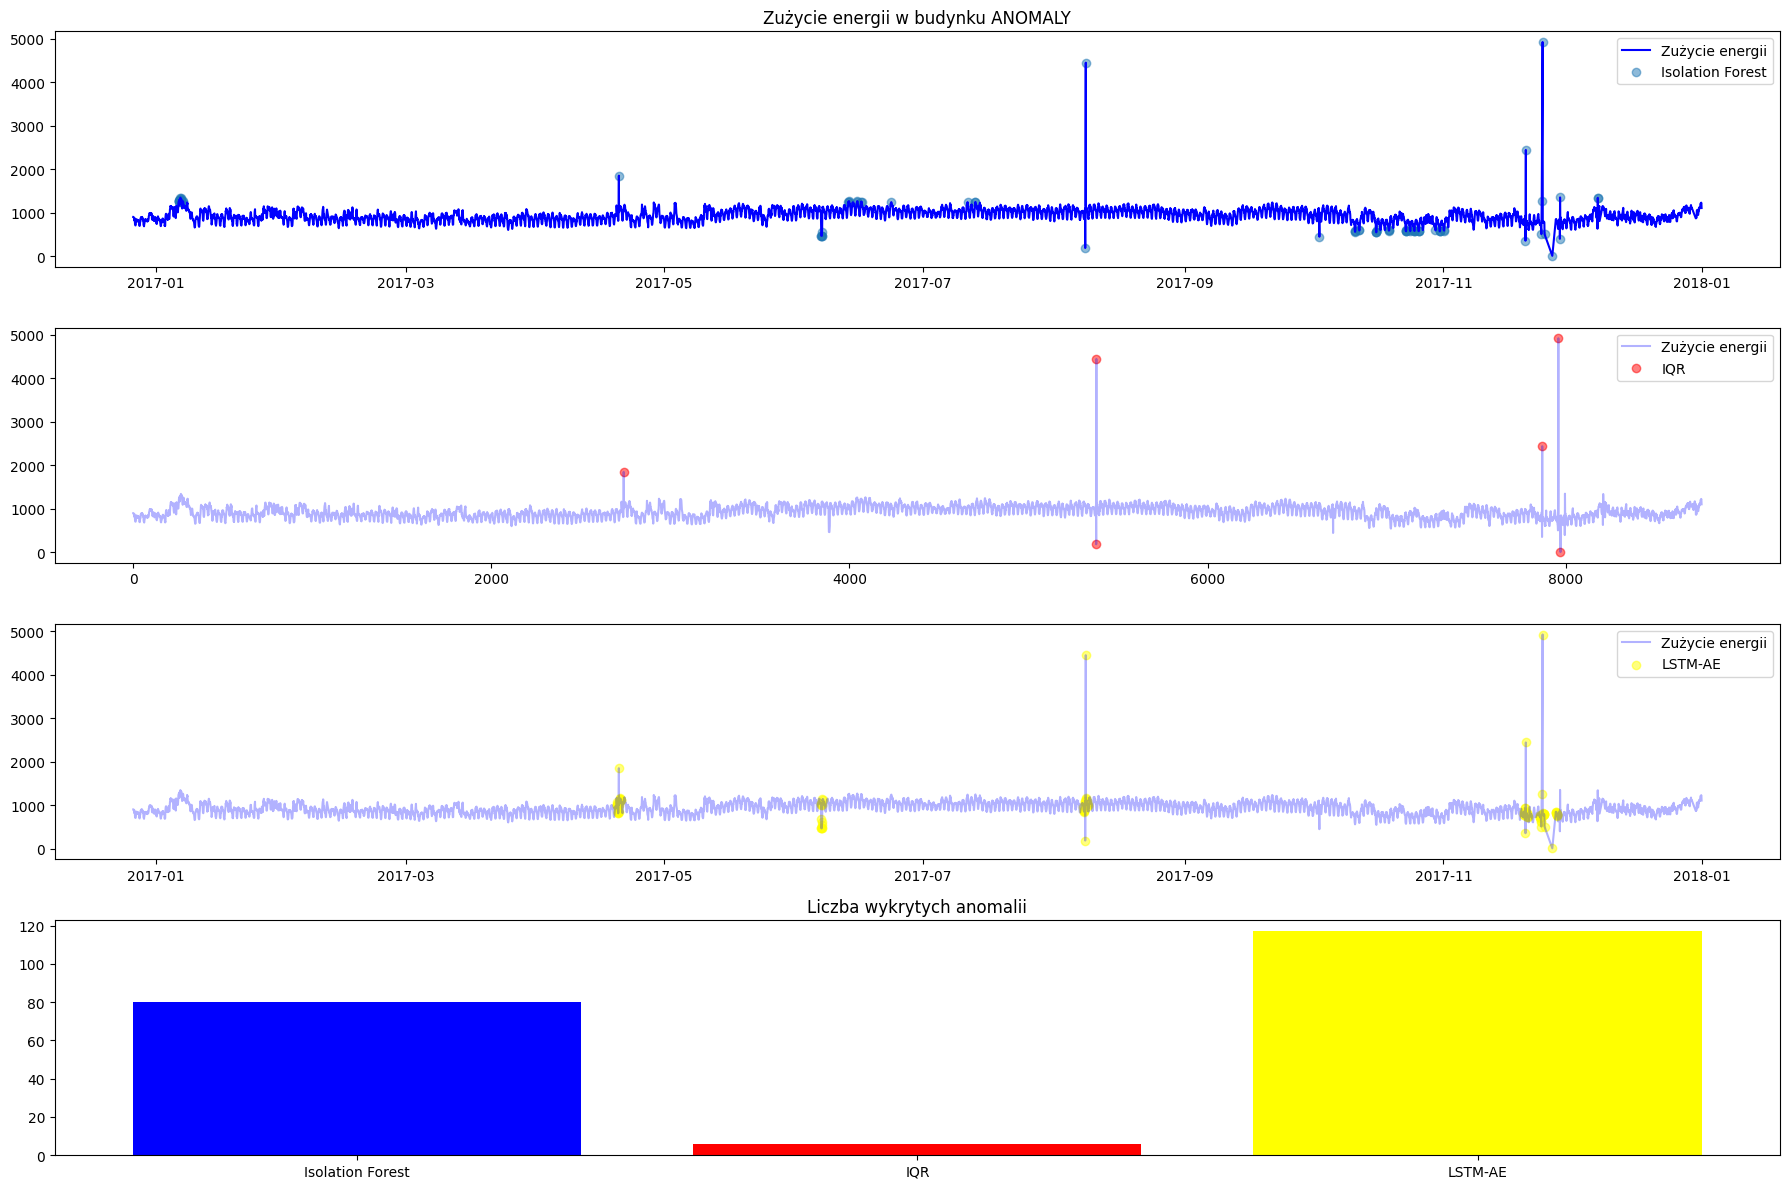

In [233]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d['timestamp'], d['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF['timestamp'][resIF['isolation_forest'] == 1], resIF['energy_consumption'][resIF['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t[resIQR].index, t[resIQR], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d['timestamp'], d['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM['timestamp'][resLSTM['lstm_autoencoder'] == 1], resLSTM['energy_consumption'][resLSTM['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = resIF[resIF['isolation_forest'] == 1].count()
counts_IQR = t[resIQR].count()
counts_LSTM = resLSTM[resLSTM['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF,color='blue')
plt.bar('IQR', counts_IQR, color='red')
plt.bar('LSTM-AE', counts_LSTM, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

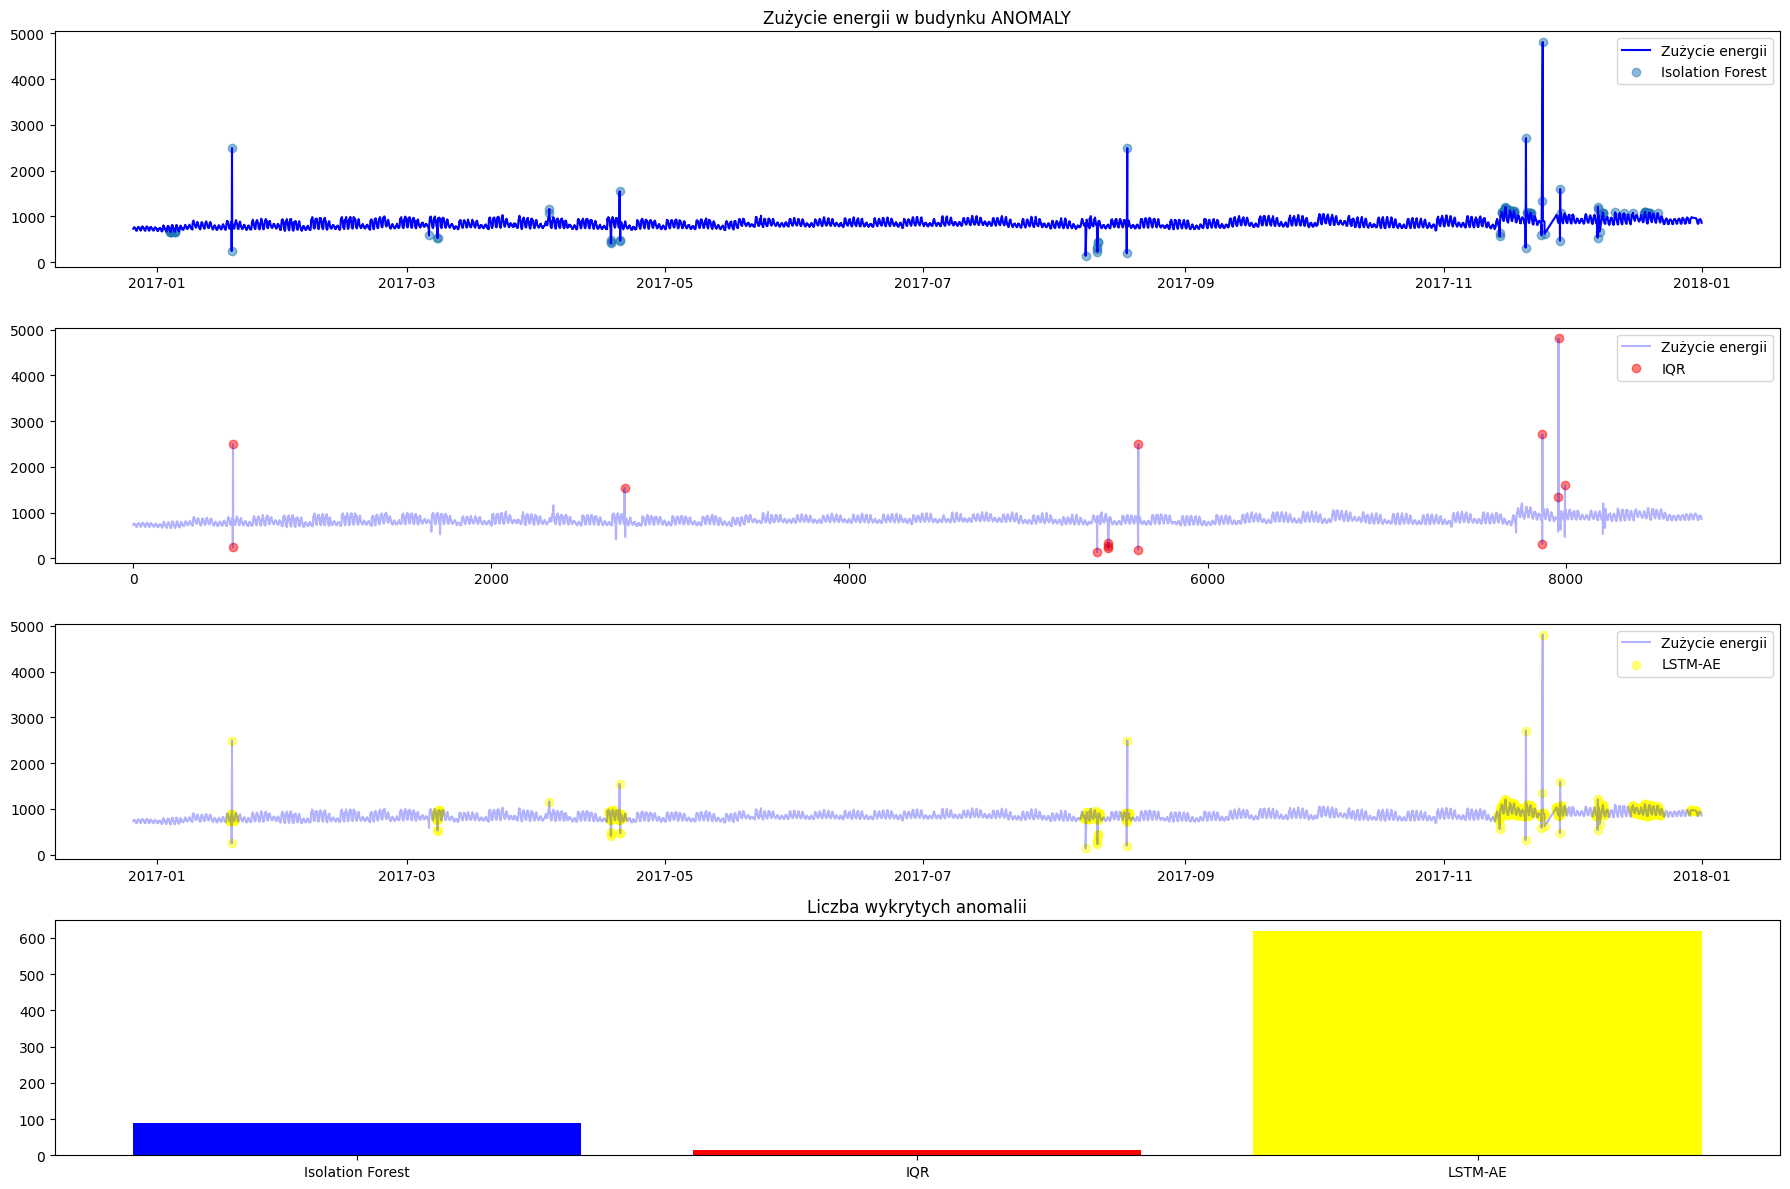

In [234]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d2['timestamp'], d2['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF2['timestamp'][resIF2['isolation_forest'] == 1], resIF2['energy_consumption'][resIF2['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t2, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t2[resIQR2].index, t2[resIQR2], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d2['timestamp'], d2['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM2['timestamp'][resLSTM2['lstm_autoencoder'] == 1], resLSTM2['energy_consumption'][resLSTM2['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF2 = resIF2[resIF2['isolation_forest'] == 1].count()
counts_IQR2 = t2[resIQR2].count()
counts_LSTM2 = resLSTM2[resLSTM2['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF2,color='blue')
plt.bar('IQR', counts_IQR2, color='red')
plt.bar('LSTM-AE', counts_LSTM2, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()

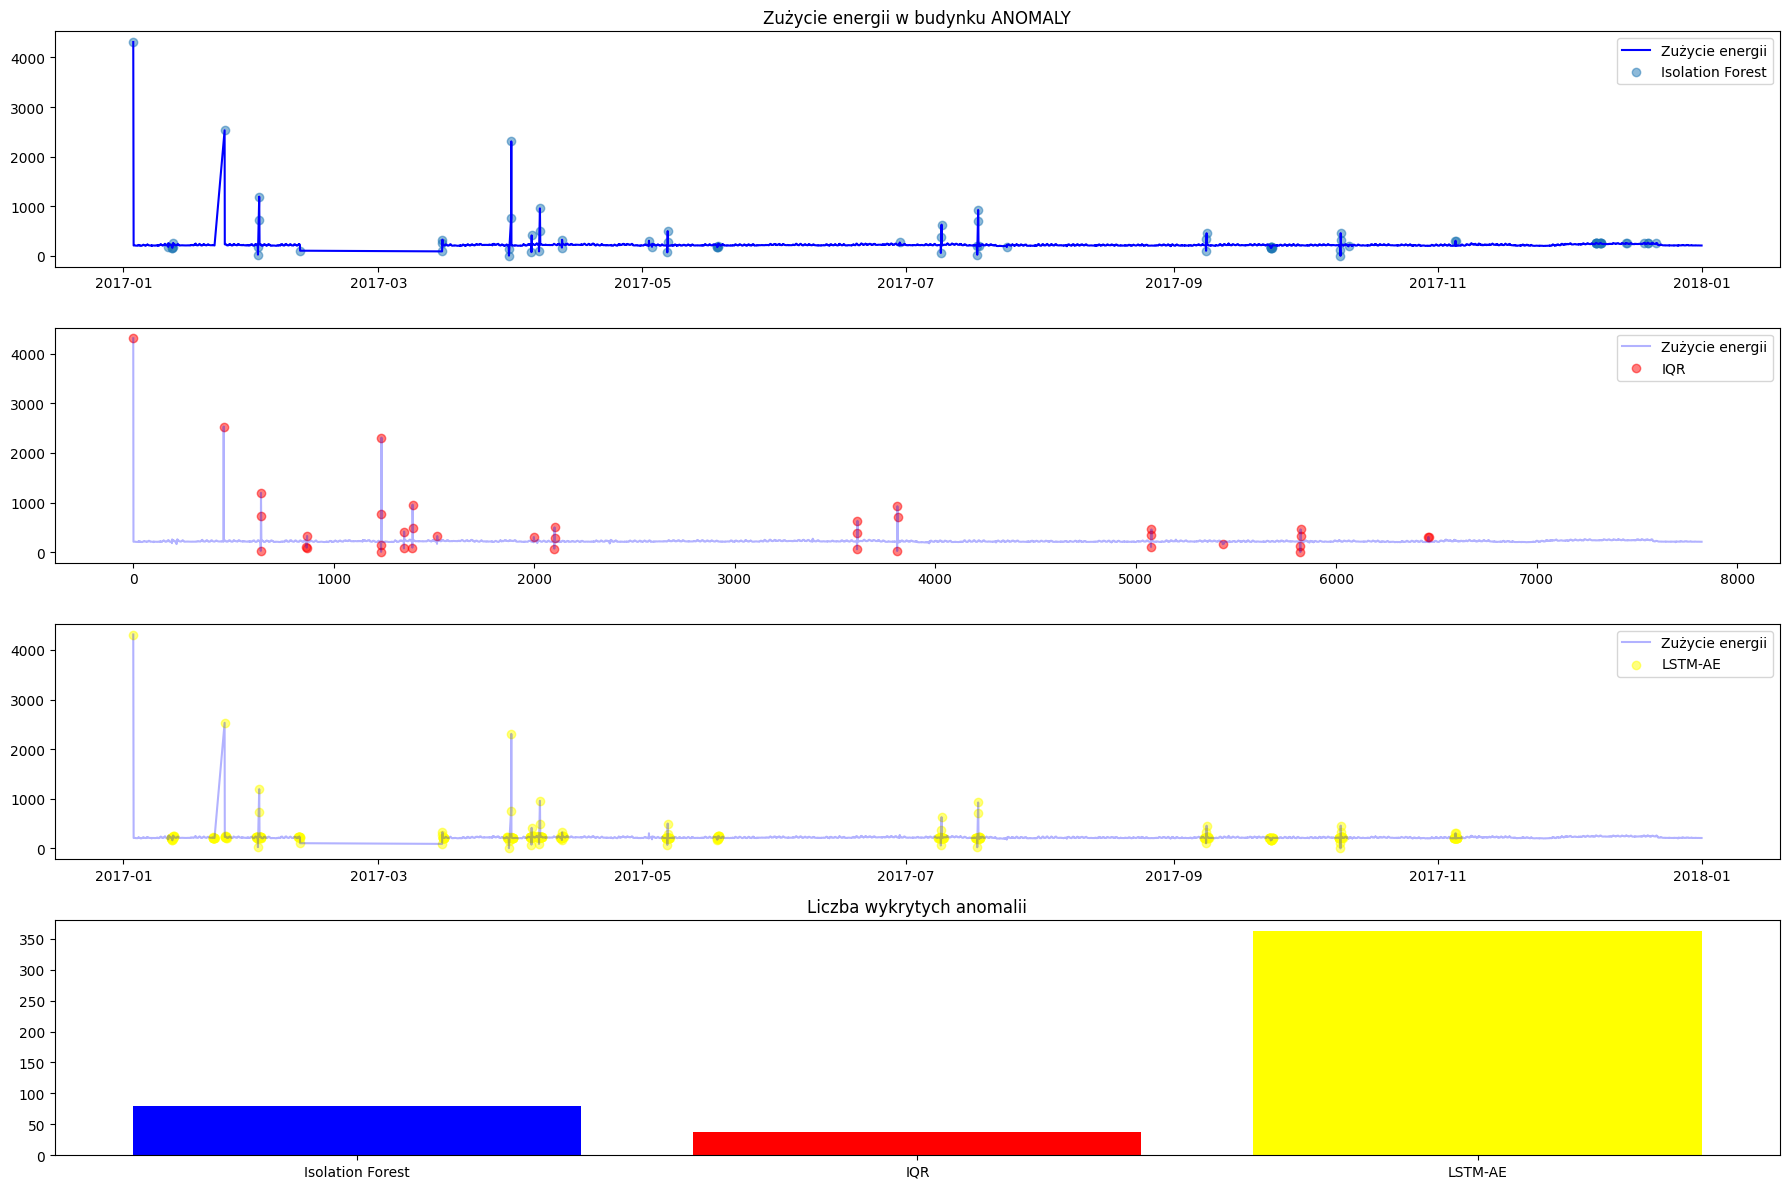

In [235]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(d3['timestamp'], d3['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(resIF3['timestamp'][resIF3['isolation_forest'] == 1], resIF3['energy_consumption'][resIF3['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t3, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(t3[resIQR3].index, t3[resIQR3], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(d3['timestamp'], d3['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(resLSTM3['timestamp'][resLSTM3['lstm_autoencoder'] == 1], resLSTM3['energy_consumption'][resLSTM3['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF3 = resIF3[resIF3['isolation_forest'] == 1].count()
counts_IQR3 = t3[resIQR3].count()
counts_LSTM3 = resLSTM3[resLSTM3['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF3,color='blue')
plt.bar('IQR', counts_IQR3, color='red')
plt.bar('LSTM-AE', counts_LSTM3, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()

In [236]:
tp = data.reset_index().drop(columns=['index'])

print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(t[resIQR].index):
    if i in list(tp[tp['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t[resIQR].index)) - c}")

c = 0

for i in list(resIF[resIF['isolation_forest'] == 1].index):
    if i in list(d[d['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF[resIF['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM[resLSTM['lstm_autoencoder'] == 1].index):
    if i in list(d[d['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d[d['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM[resLSTM['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 2 ===========")
tp2 = d2.reset_index().drop(columns=['index'])

c = 0

for i in list(t2[resIQR2].index):
    if i in list(tp2[tp2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t2[resIQR2].index)) - c}")

c = 0

for i in list(resIF2[resIF2['isolation_forest'] == 1].index):
    if i in list(d2[d2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF2[resIF2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM2[resLSTM2['lstm_autoencoder'] == 1].index):
    if i in list(d2[d2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d2[d2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM2[resLSTM2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")
tp3 = d3.reset_index().drop(columns=['index'])

c = 0

for i in list(t3[resIQR3].index):
    if i in list(tp3[tp3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t3[resIQR3].index)) - c}")

c = 0

for i in list(resIF3[resIF3['isolation_forest'] == 1].index):
    if i in list(d3[d3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(resIF3[resIF3['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(resLSTM3[resLSTM3['lstm_autoencoder'] == 1].index):
    if i in list(d3[d3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(d3[d3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(resLSTM3[resLSTM3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 6/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 0
Liczba anomalii wykrytych przez IF: 16/16
Liczba anomalii wykrytych przez IF spoza zakresu: 64
Liczba anomalii wykrytych przez LSTM-AE: 13/16
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 104
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 14/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 0
Liczba anomalii wykrytych przez IF: 47/47
Liczba anomalii wykrytych przez IF spoza zakresu: 41
Liczba anomalii wykrytych przez LSTM-AE: 46/47
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 572
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 38/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 0
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM-AE: 54/62
Liczba anomalii wykrytych przez LSTM-AE spoza 

In [237]:
import pandas as pd

# Funkcje pomocnicze pozostają bez zmian
def calculate_metrics(y_true, y_pred):
    TP = ((y_true == True) & (y_pred == True)).sum()
    FP = ((y_true == False) & (y_pred == True)).sum()
    TN = ((y_true == False) & (y_pred == False)).sum()
    FN = ((y_true == True) & (y_pred == False)).sum()
    
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1_score
    }

def evaluate_method(true_anomalies, predicted_anomalies):
    common_index = true_anomalies.index.intersection(predicted_anomalies.index)
    y_true = true_anomalies.loc[common_index]
    y_pred = predicted_anomalies.loc[common_index]
    return calculate_metrics(y_true, y_pred)

# Przygotowanie DataFrame na wyniki
results = []

# Budynek 1
true_anomalies_b1 = d['anomaly']
tp_b1 = tp['anomaly']

# IQR
iqr_pred_b1 = pd.Series(False, index=tp_b1.index)
common_idx = iqr_pred_b1.index.intersection(t[resIQR].index)
iqr_pred_b1.loc[common_idx] = True
metrics_iqr_b1 = evaluate_method(tp_b1, iqr_pred_b1)
metrics_iqr_b1.update({'Budynek': 1, 'Metoda': 'IQR'})
results.append(metrics_iqr_b1)

# Isolation Forest
if_pred_b1 = pd.Series(False, index=true_anomalies_b1.index)
if_pred_b1.loc[resIF.index] = (resIF['isolation_forest'] == 1)
metrics_if_b1 = evaluate_method(true_anomalies_b1, if_pred_b1)
metrics_if_b1.update({'Budynek': 1, 'Metoda': 'Isolation Forest'})
results.append(metrics_if_b1)

# LSTM-AE
lstm_pred_b1 = pd.Series(False, index=true_anomalies_b1.index)
lstm_pred_b1.loc[resLSTM.index] = (resLSTM['lstm_autoencoder'] == 1)
metrics_lstm_b1 = evaluate_method(true_anomalies_b1, lstm_pred_b1)
metrics_lstm_b1.update({'Budynek': 1, 'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b1)

# Budynek 2
true_anomalies_b2 = d2['anomaly']
tp_b2 = tp2['anomaly']

# IQR
iqr_pred_b2 = pd.Series(False, index=tp_b2.index)
common_idx = iqr_pred_b2.index.intersection(t2[resIQR2].index)
iqr_pred_b2.loc[common_idx] = True
metrics_iqr_b2 = evaluate_method(tp_b2, iqr_pred_b2)
metrics_iqr_b2.update({'Budynek': 2, 'Metoda': 'IQR'})
results.append(metrics_iqr_b2)

# Isolation Forest
if_pred_b2 = pd.Series(False, index=true_anomalies_b2.index)
if_pred_b2.loc[resIF2.index] = (resIF2['isolation_forest'] == 1)
metrics_if_b2 = evaluate_method(true_anomalies_b2, if_pred_b2)
metrics_if_b2.update({'Budynek': 2, 'Metoda': 'Isolation Forest'})
results.append(metrics_if_b2)

# LSTM-AE
lstm_pred_b2 = pd.Series(False, index=true_anomalies_b2.index)
lstm_pred_b2.loc[resLSTM2.index] = (resLSTM2['lstm_autoencoder'] == 1)
metrics_lstm_b2 = evaluate_method(true_anomalies_b2, lstm_pred_b2)
metrics_lstm_b2.update({'Budynek': 2, 'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b2)

# Budynek 3
true_anomalies_b3 = d3['anomaly']
tp_b3 = tp3['anomaly']

# IQR
iqr_pred_b3 = pd.Series(False, index=tp_b3.index)
common_idx = iqr_pred_b3.index.intersection(t3[resIQR3].index)
iqr_pred_b3.loc[common_idx] = True
metrics_iqr_b3 = evaluate_method(tp_b3, iqr_pred_b3)
metrics_iqr_b3.update({'Budynek': 3, 'Metoda': 'IQR'})
results.append(metrics_iqr_b3)

# Isolation Forest
if_pred_b3 = pd.Series(False, index=true_anomalies_b3.index)
if_pred_b3.loc[resIF3.index] = (resIF3['isolation_forest'] == 1)
metrics_if_b3 = evaluate_method(true_anomalies_b3, if_pred_b3)
metrics_if_b3.update({'Budynek': 3, 'Metoda': 'Isolation Forest'})
results.append(metrics_if_b3)

# LSTM-AE
lstm_pred_b3 = pd.Series(False, index=true_anomalies_b3.index)
lstm_pred_b3.loc[resLSTM3.index] = (resLSTM3['lstm_autoencoder'] == 1)
metrics_lstm_b3 = evaluate_method(true_anomalies_b3, lstm_pred_b3)
metrics_lstm_b3.update({'Budynek': 3, 'Metoda': 'LSTM-AE'})
results.append(metrics_lstm_b3)

# Tworzenie finalnego DataFrame
results_df = pd.DataFrame(results)
columns_order = ['Budynek', 'Metoda', 'TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-score']
results_df = results_df[columns_order]

# Formatowanie wyników procentowych
percent_cols = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-score']
results_df[percent_cols] = results_df[percent_cols].map(lambda x: f"{x:.2%}")

# Wyświetlenie wyników
results_df.sort_values(by=['Accuracy'])

results_df.sort_values(by=['Metoda'], inplace=True)
results_df

,Budynek,Metoda,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1-score
0,1,IQR,6,0,8744,10,99.89%,100.00%,37.50%,100.00%,54.55%
3,2,IQR,14,0,8713,33,99.62%,100.00%,29.79%,100.00%,45.90%
6,3,IQR,38,0,7761,24,99.69%,100.00%,61.29%,100.00%,76.00%
1,1,Isolation Forest,16,64,8680,0,99.27%,20.00%,100.00%,99.27%,33.33%
4,2,Isolation Forest,47,41,8672,0,99.53%,53.41%,100.00%,99.53%,69.63%
7,3,Isolation Forest,62,17,7744,0,99.78%,78.48%,100.00%,99.78%,87.94%
2,1,LSTM-AE,13,104,8640,3,98.78%,11.11%,81.25%,98.81%,19.55%
5,2,LSTM-AE,46,572,8141,1,93.46%,7.44%,97.87%,93.44%,13.83%
8,3,LSTM-AE,54,308,7453,8,95.96%,14.92%,87.10%,96.03%,25.47%


### TEST LSTM - uczenie na błędach

In [289]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import classification_report

n_steps = 24
n_features = 3  # Upewnij się, że to uwzględnia również kolumnę 'anomaly'

def prepare_data(data, target_col='anomaly', n_steps=24):
    features = data.drop(columns=[target_col])
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Dodanie kolumny anomalii do przeskalowanych danych
    scaled_data = np.column_stack((scaled_features, data[target_col].values))
    
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, :-1])
        y.append(scaled_data[i, -1]) 
        
    return np.array(X), np.array(y), scaler

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', 32, 256, step=32),
        input_shape=(n_steps, n_features-1),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Recall']
    )
    return model

def train_and_predict(train_data, test_data, target_col='anomaly'):
    X_train, y_train, scaler = prepare_data(train_data, target_col, n_steps)
    
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning_pred',
        project_name='energy_forecast'
    )
    
    tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)
    best_model = tuner.get_best_models()[0]
    
    # Przygotowanie danych testowych
    combined_features = pd.concat([train_data.drop(columns=[target_col]).iloc[-n_steps:], 
                                test_data.drop(columns=[target_col])])
    scaled_features = scaler.transform(combined_features)
    
    X_test = []
    for i in range(n_steps, len(scaled_features)):
        X_test.append(scaled_features[i-n_steps:i, :])
    X_test = np.array(X_test)
    
    # Predykcja
    anomaly_probs = best_model.predict(X_test).flatten()
    predictions = anomaly_probs > 0.006  # Domyślny próg 0.5
    
    # Przygotowanie wyników
    results = test_data.copy()
    results['anomaly_prob'] = anomaly_probs
    results['predicted_anomaly'] = predictions
    
    return results

In [290]:
train_lstm = d[['energy_consumption', 'airTemperature', 'anomaly']].iloc[:-2000]
test_lstm = d[['energy_consumption', 'airTemperature', 'anomaly']].iloc[-2000:]

predictions = train_and_predict(train_lstm, test_lstm, "anomaly")

Reloading Tuner from tuning_pred\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [291]:
predictions['predicted_anomaly'].value_counts()

predicted_anomaly
False    1936
True       64
Name: count, dtype: int64

Text(0.5, 1.0, 'Prognozy LSTM vs Prawdziwe wartości')

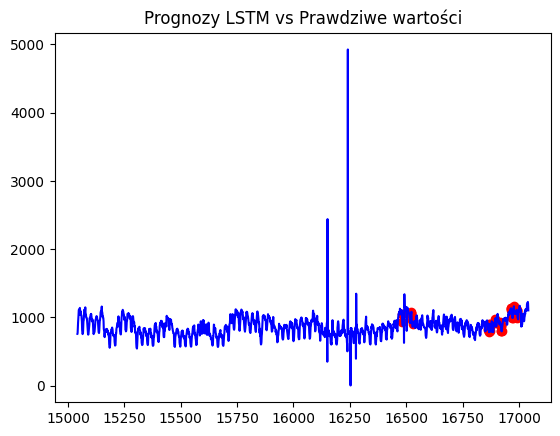

In [292]:
plt.plot(test_lstm.index, test_lstm['energy_consumption'], label='Prawdziwe wartości', color='blue')
plt.scatter(predictions[predictions['predicted_anomaly']].index, predictions[predictions['predicted_anomaly']]['energy_consumption'], label='Prognozy LSTM', color='red')
plt.title('Prognozy LSTM vs Prawdziwe wartości')

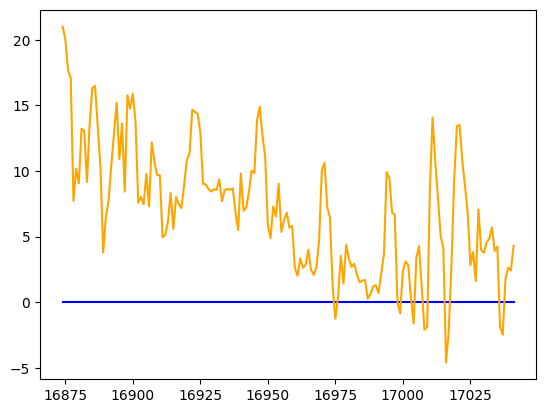

In [244]:
plt.plot(test_lstm.index, true_values, label='Prawdziwe wartości', color='blue')
plt.plot(test_lstm.index, predictions, label='Prognozy LSTM', color='orange')